In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U transformers accelerate datasets evaluate rouge-score

In [ ]:
# ============================================================
# ⚡ BART Fine-Tuning with LoRA/PEFT (Memory-Efficient, Kaggle)
# ============================================================
import os
import gc
import psutil
import torch
from datetime import datetime
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    TrainerCallback,
)
from peft import LoraConfig, get_peft_model, TaskType


# ============================================================
# 🚀 Kaggle Setup
# ============================================================
os.environ["WANDB_DISABLED"] = "true"  # disable wandb on Kaggle
os.environ["TOKENIZERS_PARALLELISM"] = "false"
OUTPUT_DIR = "/kaggle/working/bart-lora-model"

# ============================================================
# Aggressive Memory Cleanup
# ============================================================
def clear_memory():
    print("🧹 Clearing CPU + GPU memory...")
    for obj in list(globals().keys()):
        if isinstance(globals()[obj], torch.Tensor):
            del globals()[obj]
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    process = psutil.Process(os.getpid())
    print(f"CPU Memory used: {process.memory_info().rss / 1e9:.2f} GB")
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    print("✅ Memory cleanup done\n")

clear_memory()

# ============================================================
# Sample dataset setup (replace with your own `filtered_df`)
# ============================================================
# Example mock dataset for demonstration

filtered_df = pd.read_csv("/kaggle/input/filtered-samples/filtered_train.csv")

# ============================================================
# Progress Tracker (with epoch summary)
# ============================================================
class DetailedProgressCallback(TrainerCallback):
    def __init__(self):
        self.start_time = None
        self.epoch_logs = {}
        self._last_train_loss = None

    def on_train_begin(self, args, state, control, **kwargs):
        from datetime import datetime
        self.start_time = datetime.now()
        print(f"\n🚀 Training started at: {self.start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    def _print_epoch_line(self, args, state, train_loss=None, eval_loss=None):
        from datetime import datetime
        if self.start_time is None:
            return
        elapsed = datetime.now() - self.start_time
        epochs_done = int(state.epoch) if state.epoch is not None else 0
        total_epochs = int(args.num_train_epochs)
        time_per_epoch = elapsed / max(epochs_done, 1)
        remaining = time_per_epoch * max(total_epochs - epochs_done, 0)

        print(f"[Epoch {epochs_done}/{total_epochs}] ⏱️ Elapsed: {str(elapsed).split('.')[0]} | "
              f"Remaining: {str(remaining).split('.')[0]}")
        if train_loss is not None or eval_loss is not None:
            print("Epoch\tTraining Loss\tValidation Loss")
            print(f"{epochs_done}\t"
                  f"{(train_loss if train_loss is not None else float('nan')):.6f}\t"
                  f"{(eval_loss  if eval_loss  is not None else float('nan')):.6f}\n")

    # called frequently with minibatch logs
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        if "loss" in logs:
            self._last_train_loss = float(logs["loss"])

    # called after evaluation with metrics dict
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        eval_loss = None
        if metrics and "eval_loss" in metrics:
            eval_loss = float(metrics["eval_loss"])
        self.epoch_logs[int(state.epoch or 0)] = {
            "train_loss": self._last_train_loss,
            "eval_loss": eval_loss,
        }
        self._print_epoch_line(args, state, train_loss=self._last_train_loss, eval_loss=eval_loss)

    # still show timing even if no eval ran (e.g., last epoch if mis-configured)
    def on_epoch_end(self, args, state, control, **kwargs):
        self._print_epoch_line(args, state, train_loss=self._last_train_loss,
                               eval_loss=self.epoch_logs.get(int(state.epoch or 0), {}).get("eval_loss"))

class KeepAliveCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 50 == 0:
            print("Training is still running...")
# ============================================================
# Data Preparation
# ============================================================
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_ds = Dataset.from_pandas(filtered_df[['document', 'summary']])
split_ds = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = split_ds["train"], split_ds["test"]

print(f"📊 Training samples: {len(train_ds)}")
print(f"📊 Validation samples: {len(val_ds)}")

# ============================================================
# Tokenizer & Preprocessing
# ============================================================
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = tokenizer(
        examples["document"],
        max_length=512,
        truncation=True,
        padding="max_length",
    )
    targets = tokenizer(
        examples["summary"],
        max_length=300,
        truncation=True,
        padding="max_length",
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

print("🔄 Tokenizing datasets...")
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
clear_memory()

# ============================================================
# Load Model + Apply LoRA
# ============================================================
print("📥 Loading BART-large model...")
model = BartForConditionalGeneration.from_pretrained(model_name)

print("🔧 Applying LoRA configuration...")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
    inference_mode=False,
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
clear_memory()

# ============================================================
# Training Arguments
# ============================================================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=500,
    logging_first_step=True,
    fp16=True,
    dataloader_num_workers=2,
    report_to="none",
    dataloader_pin_memory=False,
    gradient_checkpointing=False,
    optim="adamw_torch",
)

# ============================================================
# Trainer
# ============================================================
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
        DetailedProgressCallback(),
        KeepAliveCallback(),
    ],
)

# ============================================================
# TRAIN
# ============================================================
print("\n🚀 Starting training...\n💡 LoRA reduces memory by ~60%, training should complete smoothly!\n")
checkpoints = [d for d in os.listdir(OUTPUT_DIR) if d.startswith("checkpoint-")]
if checkpoints:
    latest = max(checkpoints, key=lambda x: int(x.split("-")[1]))
    print(f"🔄 Resuming from checkpoint: {latest}")
    trainer.train(resume_from_checkpoint=os.path.join(OUTPUT_DIR, latest))
else:
    trainer.train()

# ============================================================
# SAVE LoRA weights
# ============================================================
final_path = f"{OUTPUT_DIR}/final"
model.save_pretrained(final_path)
tokenizer.save_pretrained(final_path)
print(f"💾 LoRA adapter saved to: {final_path}")
print(f"📦 Size: ~10MB (vs ~1.6GB full model)\n")

# ============================================================
# Evaluation
# ============================================================
print("📈 Final evaluation...")
final_results = trainer.evaluate()
for k, v in final_results.items():
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")

print(f"\n✅ Training completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
# Save training summary
# ============================================================
with open(f"{OUTPUT_DIR}/training_info.txt", "w") as f:
    f.write("=" * 50 + "\nLORA TRAINING SUMMARY\n" + "=" * 50 + "\n\n")
    f.write(f"Base Model: {model_name}\n")
    f.write(f"LoRA Rank: 16 | Alpha: 32 | Modules: q_proj, v_proj\n\n")
    f.write(f"Training samples: {len(train_ds)}\nValidation samples: {len(val_ds)}\n\n")
    f.write("Final Evaluation:\n")
    for k, v in final_results.items():
        if isinstance(v, (int, float)):
            f.write(f"{k}: {v:.4f}\n")

print("📄 Training info saved!")

2025-11-07 19:01:11.543894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1762542071.742562     111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762542071.797368     111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🧹 Clearing CPU + GPU memory...
CPU Memory used: 1.44 GB
GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB
✅ Memory cleanup done

📊 Training samples: 21943
📊 Validation samples: 2439
vocab.json: 
 899k/? [00:00<00:00, 18.5MB/s]
merges.txt: 
 456k/? [00:00<00:00, 27.8MB/s]
tokenizer.json: 
 1.36M/? [00:00<00:00, 65.8MB/s]
config.json: 
 1.58k/? [00:00<00:00, 177kB/s]
🔄 Tokenizing datasets...
Map: 100%
 21943/21943 [02:01<00:00, 182.97 examples/s]
Map: 100%
 2439/2439 [00:14<00:00, 170.55 examples/s]
🧹 Clearing CPU + GPU memory...
CPU Memory used: 1.86 GB
GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB
✅ Memory cleanup done

📥 Loading BART-large model...
model.safetensors: 100%
 1.63G/1.63G [00:05<00:00, 756MB/s]
generation_config.json: 100%
 363/363 [00:00<00:00, 33.9kB/s]
🔧 Applying LoRA configuration...
trainable params: 2,359,296 || all params: 408,649,728 || trainable%: 0.5773
🧹 Clearing CPU + GPU memory...
CPU Memory used: 2.06 GB
GPU Memory allocated: 0.00 GB
GPU Memory reserved: 0.00 GB
✅ Memory cleanup done


🚀 Starting training...
💡 LoRA reduces memory by ~60%, training should complete smoothly!


🚀 Training started at: 2025-11-07 19:03:57
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
 [13720/13720 10:50:01, Epoch 10/10]
Epoch	Training Loss	Validation Loss
1	2.059800	1.858989
2	1.969000	1.815505
3	1.928500	1.794550
4	1.908100	1.780970
5	1.901900	1.769263
6	1.870100	1.761756
7	1.866500	1.755539
8	1.874800	1.753439
9	1.846800	1.750842
10	1.853500	1.749765
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 1/10] ⏱️ Elapsed: 1:00:46 | Remaining: 9:07:00
Epoch	Training Loss	Validation Loss
1	2.059800	nan

[Epoch 1/10] ⏱️ Elapsed: 1:04:44 | Remaining: 9:42:42
Epoch	Training Loss	Validation Loss
1	2.059800	1.858989

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 2/10] ⏱️ Elapsed: 2:05:40 | Remaining: 8:22:40
Epoch	Training Loss	Validation Loss
2	1.969000	nan

[Epoch 2/10] ⏱️ Elapsed: 2:09:38 | Remaining: 8:38:32
Epoch	Training Loss	Validation Loss
2	1.969000	1.815505

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 3/10] ⏱️ Elapsed: 3:10:34 | Remaining: 7:24:39
Epoch	Training Loss	Validation Loss
3	1.928500	nan

[Epoch 3/10] ⏱️ Elapsed: 3:14:31 | Remaining: 7:33:53
Epoch	Training Loss	Validation Loss
3	1.928500	1.794550

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 4/10] ⏱️ Elapsed: 4:15:27 | Remaining: 6:23:11
Epoch	Training Loss	Validation Loss
4	1.908100	nan

[Epoch 4/10] ⏱️ Elapsed: 4:19:25 | Remaining: 6:29:07
Epoch	Training Loss	Validation Loss
4	1.908100	1.780970

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 5/10] ⏱️ Elapsed: 5:20:21 | Remaining: 5:20:21
Epoch	Training Loss	Validation Loss
5	1.901900	nan

[Epoch 5/10] ⏱️ Elapsed: 5:24:19 | Remaining: 5:24:19
Epoch	Training Loss	Validation Loss
5	1.901900	1.769263

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 6/10] ⏱️ Elapsed: 6:25:16 | Remaining: 4:16:50
Epoch	Training Loss	Validation Loss
6	1.870100	nan

[Epoch 6/10] ⏱️ Elapsed: 6:29:14 | Remaining: 4:19:29
Epoch	Training Loss	Validation Loss
6	1.870100	1.761756

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 7/10] ⏱️ Elapsed: 7:30:11 | Remaining: 3:12:56
Epoch	Training Loss	Validation Loss
7	1.866500	nan

[Epoch 7/10] ⏱️ Elapsed: 7:34:09 | Remaining: 3:14:38
Epoch	Training Loss	Validation Loss
7	1.866500	1.755539

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 8/10] ⏱️ Elapsed: 8:35:07 | Remaining: 2:08:46
Epoch	Training Loss	Validation Loss
8	1.874800	nan

[Epoch 8/10] ⏱️ Elapsed: 8:39:05 | Remaining: 2:09:46
Epoch	Training Loss	Validation Loss
8	1.874800	1.753439

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 9/10] ⏱️ Elapsed: 9:40:26 | Remaining: 1:04:29
Epoch	Training Loss	Validation Loss
9	1.846800	nan

[Epoch 9/10] ⏱️ Elapsed: 9:44:28 | Remaining: 1:04:56
Epoch	Training Loss	Validation Loss
9	1.846800	1.750842

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
Training is still running...
[Epoch 10/10] ⏱️ Elapsed: 10:46:01 | Remaining: 0:00:00
Epoch	Training Loss	Validation Loss
10	1.853500	nan

[Epoch 10/10] ⏱️ Elapsed: 10:50:04 | Remaining: 0:00:00
Epoch	Training Loss	Validation Loss
10	1.853500	1.749765

💾 LoRA adapter saved to: /kaggle/working/bart-lora-model/final
📦 Size: ~10MB (vs ~1.6GB full model)

📈 Final evaluation...
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
 [610/610 04:03]
[Epoch 10/10] ⏱️ Elapsed: 10:54:09 | Remaining: 0:00:00
Epoch	Training Loss	Validation Loss
10	1.853500	1.749765

eval_loss: 1.7498
eval_runtime: 243.5800
eval_samples_per_second: 10.0130
eval_steps_per_second: 2.5040
epoch: 10.0000

✅ Training completed at: 2025-11-08 05:58:06
📄 Training info saved!

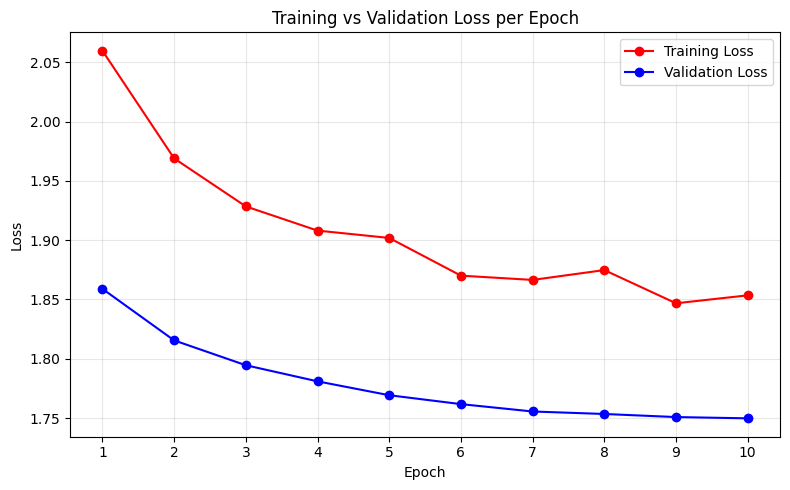

Saved as loss_curve.png


In [1]:
import matplotlib.pyplot as plt

# --------------------------
# Your data
# --------------------------
epochs = [1,2,3,4,5,6,7,8,9,10]

train_loss = [
    2.059800, 1.969000, 1.928500, 1.908100, 1.901900,
    1.870100, 1.866500, 1.874800, 1.846800, 1.853500
]

val_loss = [
    1.858989, 1.815505, 1.794550, 1.780970, 1.769263,
    1.761756, 1.755539, 1.753439, 1.750842, 1.749765
]

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(8,5))

# training loss (red)
plt.plot(epochs, train_loss, marker='o', color='red', label='Training Loss')

# validation loss (blue)
plt.plot(epochs, val_loss, marker='o', color='blue', label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss per Epoch")
plt.xticks(epochs)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()
print("Saved as loss_curve.png")

In [4]:
import plotly.graph_objects as go

epochs = list(range(1, 11))
train_loss = [2.059800, 1.969000, 1.928500, 1.908100, 1.901900, 1.870100, 1.866500, 1.874800, 1.846800, 1.853500]
val_loss   = [1.858989, 1.815505, 1.794550, 1.780970, 1.769263, 1.761756, 1.755539, 1.753439, 1.750842, 1.749765]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=epochs, y=train_loss,
    mode='lines+markers',
    name='Training Loss',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=epochs, y=val_loss,
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='blue')
))

fig.update_layout(
    title="Interactive Training vs Validation Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    hovermode="x unified"
)

fig.show()

In [ ]:
!zip -r work.zip /kaggle/working/*

In [1]:
!pip uninstall -y transformers huggingface_hub tokenizers
!pip install transformers==4.52.4 huggingface_hub==0.25.2 tokenizers==0.21.0


Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: huggingface-hub 1.0.0rc2
Uninstalling huggingface-hub-1.0.0rc2:
  Successfully uninstalled huggingface-hub-1.0.0rc2
Found existing installation: tokenizers 0.21.2
Uninstalling tokenizers-0.21.2:
  Successfully uninstalled tokenizers-0.21.2
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install huggingface_hub==0.25.2 and transformers==4.52.4 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested huggingface_hub==0.25.2
    transformers 4.52.4 depends on huggingface-hub<1.0 and >=0.30.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERR

In [2]:
pip install -U transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 78.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.7 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
from datasets import Dataset
from transformers import BartTokenizer
filtered_df = pd.read_csv("/kaggle/input/filtered-samples/filtered_train.csv")
train_ds = Dataset.from_pandas(filtered_df[['document', 'summary']])
split_ds = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds, val_ds = split_ds["train"], split_ds["test"]

print(f"📊 Training samples: {len(train_ds)}")
print(f"📊 Validation samples: {len(val_ds)}")

# ============================================================
# Tokenizer & Preprocessing
# ============================================================
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    inputs = tokenizer(
        examples["document"],
        max_length=512,
        truncation=True,
        padding="max_length",
    )
    targets = tokenizer(
        examples["summary"],
        max_length=300,
        truncation=True,
        padding="max_length",
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

print("🔄 Tokenizing datasets...")
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tokenized_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)

📊 Training samples: 21943
📊 Validation samples: 2439


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

🔄 Tokenizing datasets...


Map:   0%|          | 0/21943 [00:00<?, ? examples/s]

Map:   0%|          | 0/2439 [00:00<?, ? examples/s]

In [5]:
!pip install evaluate rouge_score

In [ ]:
import evaluate
from tqdm.auto import tqdm
import numpy as np
import torch
from transformers import BartTokenizer,BartForConditionalGeneration
rouge = evaluate.load("rouge")

model_dir = "/kaggle/input/merged-final/kaggle/working/bart-lora-complete-model/merged-final"
model = BartForConditionalGeneration.from_pretrained(model_dir).to("cuda").eval()

def generate_summary(batch):
    inputs = tokenizer(batch["document"], return_tensors="pt", truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        summary_ids = model.generate(
            **inputs,
            max_length=220,
            num_beams=5,
            no_repeat_ngram_size=3,
            length_penalty=1.0,
            early_stopping=True
        )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

preds = []
refs = []

for example in tqdm(val_ds):
    preds.append(generate_summary(example))
    refs.append(example["summary"])
    print("Still Running")

results = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
for k, v in results.items():
    print(f"{k}: {v*100:.2f}")

In [6]:
import evaluate
from tqdm.auto import tqdm
import numpy as np
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Load tokenizer+model from the SAME dir as your merged adapter
model_dir = "/kaggle/input/merged-final/kaggle/working/bart-lora-complete-model/merged-final"
tokenizer = BartTokenizer.from_pretrained(model_dir)
model = BartForConditionalGeneration.from_pretrained(model_dir).to(device).eval()

rouge = evaluate.load("rouge")

# 2) Shared generation settings (keep these fixed across models for fair comparison)
gen_kwargs = dict(
    num_beams=5,
    no_repeat_ngram_size=3,
    length_penalty=1.0,
    early_stopping=True,
    max_length=220
)

# 3) Batched generation to speed up + keep the cell "active"
BATCH_SIZE = 16  # adjust to VRAM; 8–32 is typical for 16GB
preds, refs = [], []

for i in tqdm(range(0, len(val_ds), BATCH_SIZE)):
    batch = val_ds[i : i + BATCH_SIZE]
    docs = batch["document"]
    refs.extend(batch["summary"])

    inputs = tokenizer(
        docs,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    ).to(device)

    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.float32, enabled=(device=="cuda")):
            out = model.generate(**inputs, **gen_kwargs)

    preds.extend(tokenizer.batch_decode(out, skip_special_tokens=True))

# 4) ROUGE
results = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
for k, v in results.items():
    print(f"{k}: {v*100:.2f}")

2025-11-09 16:12:31.908541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762704752.118308      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762704752.193185      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


  0%|          | 0/153 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1733: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


rouge1: 39.76
rouge2: 18.94
rougeL: 25.31
rougeLsum: 25.33


Downloading builder script: 
 6.27k/? [00:00<00:00, 626kB/s]
100%
 153/153 [1:45:36<00:00, 34.42s/it]
rouge1: 39.76
rouge2: 18.94
rougeL: 25.31
rougeLsum: 25.33

In [ ]:
from peft import PeftModel
from transformers import BartForConditionalGeneration, BartTokenizer

adapter_dir = "/kaggle/input/peft-model/kaggle/working/bart-lora-model/final"
out_dir = "/kaggle/working/bart-lora-complete-model/merged-final"

# ✅ Load tokenizer from your LoRA folder (not from base)
tokenizer = BartTokenizer.from_pretrained(adapter_dir)
tokenizer.save_pretrained(out_dir)

# ✅ Load base model
base_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# ✅ Load LoRA weights into base model
lora_model = PeftModel.from_pretrained(base_model, adapter_dir)

# ✅ Merge LoRA weights into the model
merged_model = lora_model.merge_and_unload()

# ✅ Save final standalone model
merged_model.save_pretrained(out_dir)

print("✅ Standalone merged model + tokenizer saved!")

In [ ]:
!zip -r work-complete.zip /kaggle/working/*

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

model_dir = "/kaggle/input/merged-final/kaggle/working/bart-lora-complete-model/merged-final"

tokenizer = BartTokenizer.from_pretrained(model_dir)
model = BartForConditionalGeneration.from_pretrained(model_dir).to("cuda").eval()

text = """Title: Service Agreement Excerpt
This Service Agreement is made and entered into as of the Effective Date between the Client and the Provider, collectively referred to as the Parties. The purpose of this Agreement is to set forth the terms and conditions under which the Provider will deliver certain consulting, advisory, or technical services to the Client. The Parties acknowledge that they have had the opportunity to review the terms contained herein and voluntarily agree to be bound by them.
Scope of Services. The Provider agrees to perform the services described in Exhibit A attached hereto. Any additional services requested by the Client that are beyond the scope defined in Exhibit A shall require a written amendment signed by both Parties. The Provider shall make reasonable efforts to complete tasks in a timely and professional manner consistent with industry standards.
Compensation and Payment Terms. The Client agrees to pay the Provider the fees set forth in Exhibit B. Payments are due within thirty (30) days of the date of the invoice. In the event of late payment, the Provider may charge interest at a rate not to exceed the maximum permitted by applicable law. The Provider reserves the right to suspend work if payments are excessively delayed.
Confidentiality. Both Parties agree to maintain the confidentiality of any proprietary or sensitive information disclosed during the term of this Agreement. Confidential Information shall not include information that is already publicly available, independently developed without reference to the disclosing Party’s information, or required to be disclosed by law. Upon termination, each Party shall return or destroy any Confidential Information belonging to the other.
Term and Termination. This Agreement shall commence on the Effective Date and remain in effect for one year unless terminated earlier. Either Party may terminate the Agreement for any reason upon providing thirty (30) days’ written notice. If terminated, the Client shall pay the Provider for all services rendered up to the effective date of termination.
Limitation of Liability. Except in cases of willful misconduct or gross negligence, neither Party shall be liable for indirect, incidental, or consequential damages arising under this Agreement
This Agreement constitutes the entire understanding between the Parties and supersedes all prior negotiations or representations."""

inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")

with torch.no_grad():
    summary_ids = model.generate(
    **inputs,
    max_length=220, min_length=80,
    num_beams=5, length_penalty=1.0,
    no_repeat_ngram_size=3
)


print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

model_dir = "/kaggle/input/merged-final/kaggle/working/bart-lora-complete-model/merged-final"

tokenizer = BartTokenizer.from_pretrained(model_dir)
model = BartForConditionalGeneration.from_pretrained(model_dir).to("cuda").eval()

text = """Title: Service Agreement Excerpt
This Service Agreement is made and entered into as of the Effective Date between the Client and the Provider, collectively referred to as the Parties. The purpose of this Agreement is to set forth the terms and conditions under which the Provider will deliver certain consulting, advisory, or technical services to the Client. The Parties acknowledge that they have had the opportunity to review the terms contained herein and voluntarily agree to be bound by them.
Scope of Services. The Provider agrees to perform the services described in Exhibit A attached hereto. Any additional services requested by the Client that are beyond the scope defined in Exhibit A shall require a written amendment signed by both Parties. The Provider shall make reasonable efforts to complete tasks in a timely and professional manner consistent with industry standards.
Compensation and Payment Terms. The Client agrees to pay the Provider the fees set forth in Exhibit B. Payments are due within thirty (30) days of the date of the invoice. In the event of late payment, the Provider may charge interest at a rate not to exceed the maximum permitted by applicable law. The Provider reserves the right to suspend work if payments are excessively delayed.
Confidentiality. Both Parties agree to maintain the confidentiality of any proprietary or sensitive information disclosed during the term of this Agreement. Confidential Information shall not include information that is already publicly available, independently developed without reference to the disclosing Party’s information, or required to be disclosed by law. Upon termination, each Party shall return or destroy any Confidential Information belonging to the other.
Term and Termination. This Agreement shall commence on the Effective Date and remain in effect for one year unless terminated earlier. Either Party may terminate the Agreement for any reason upon providing thirty (30) days’ written notice. If terminated, the Client shall pay the Provider for all services rendered up to the effective date of termination.
Limitation of Liability. Except in cases of willful misconduct or gross negligence, neither Party shall be liable for indirect, incidental, or consequential damages arising under this Agreement
This Agreement constitutes the entire understanding between the Parties and supersedes all prior negotiations or representations."""

inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")

with torch.no_grad():
    summary_ids = model.generate(
        **inputs,
        max_length=220,
        num_beams=5,
        no_repeat_ngram_size=3,
        length_penalty=1.0,
        early_stopping=True
    )
print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

In [ ]:
text = """Title: Service Agreement Excerpt
This Service Agreement is made and entered into as of the Effective Date between the Client and the Provider, collectively referred to as the Parties. The purpose of this Agreement is to set forth the terms and conditions under which the Provider will deliver certain consulting, advisory, or technical services to the Client. The Parties acknowledge that they have had the opportunity to review the terms contained herein and voluntarily agree to be bound by them.
Scope of Services. The Provider agrees to perform the services described in Exhibit A attached hereto. Any additional services requested by the Client that are beyond the scope defined in Exhibit A shall require a written amendment signed by both Parties. The Provider shall make reasonable efforts to complete tasks in a timely and professional manner consistent with industry standards.
Compensation and Payment Terms. The Client agrees to pay the Provider the fees set forth in Exhibit B. Payments are due within thirty (30) days of the date of the invoice. In the event of late payment, the Provider may charge interest at a rate not to exceed the maximum permitted by applicable law. The Provider reserves the right to suspend work if payments are excessively delayed.
Confidentiality. Both Parties agree to maintain the confidentiality of any proprietary or sensitive information disclosed during the term of this Agreement. Confidential Information shall not include information that is already publicly available, independently developed without reference to the disclosing Party’s information, or required to be disclosed by law. Upon termination, each Party shall return or destroy any Confidential Information belonging to the other.
Term and Termination. This Agreement shall commence on the Effective Date and remain in effect for one year unless terminated earlier. Either Party may terminate the Agreement for any reason upon providing thirty (30) days’ written notice. If terminated, the Client shall pay the Provider for all services rendered up to the effective date of termination.
Limitation of Liability. Except in cases of willful misconduct or gross negligence, neither Party shall be liable for indirect, incidental, or consequential damages arising under this Agreement
This Agreement constitutes the entire understanding between the Parties and supersedes all prior negotiations or representations."""


prompt = f"""
You are a professional Legal document summarizer, Your task is to 
Summarize the following legal contract focusing on:
- Scope of services and required documentation
- Payment terms and consequences of non-payment
- Confidentiality duties and exceptions
- Term, termination rights, and obligations at termination
- Liability limitations
- Whether the agreement replaces prior negotiations

Document:
{text}
"""

inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")

with torch.no_grad():
    summary_ids = model.generate(
        **inputs,
        max_length=220,
        num_beams=5,
        no_repeat_ngram_size=3,
        length_penalty=1.0,
        early_stopping=True
    )

print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))


In [ ]:
text = """Title: Service Agreement Excerpt
This Service Agreement is made and entered into as of the Effective Date between the Client and the Provider, collectively referred to as the Parties. The purpose of this Agreement is to set forth the terms and conditions under which the Provider will deliver certain consulting, advisory, or technical services to the Client. The Parties acknowledge that they have had the opportunity to review the terms contained herein and voluntarily agree to be bound by them.
Scope of Services. The Provider agrees to perform the services described in Exhibit A attached hereto. Any additional services requested by the Client that are beyond the scope defined in Exhibit A shall require a written amendment signed by both Parties. The Provider shall make reasonable efforts to complete tasks in a timely and professional manner consistent with industry standards.
Compensation and Payment Terms. The Client agrees to pay the Provider the fees set forth in Exhibit B. Payments are due within thirty (30) days of the date of the invoice. In the event of late payment, the Provider may charge interest at a rate not to exceed the maximum permitted by applicable law. The Provider reserves the right to suspend work if payments are excessively delayed.
Confidentiality. Both Parties agree to maintain the confidentiality of any proprietary or sensitive information disclosed during the term of this Agreement. Confidential Information shall not include information that is already publicly available, independently developed without reference to the disclosing Party’s information, or required to be disclosed by law. Upon termination, each Party shall return or destroy any Confidential Information belonging to the other.
Term and Termination. This Agreement shall commence on the Effective Date and remain in effect for one year unless terminated earlier. Either Party may terminate the Agreement for any reason upon providing thirty (30) days’ written notice. If terminated, the Client shall pay the Provider for all services rendered up to the effective date of termination.
Limitation of Liability. Except in cases of willful misconduct or gross negligence, neither Party shall be liable for indirect, incidental, or consequential damages arising under this Agreement
This Agreement constitutes the entire understanding between the Parties and supersedes all prior negotiations or representations."""


prompt = f"""
Summarize the following contract clearly and concisely. Include:
1) What services are provided and where they are defined (e.g., Exhibit A)
2) Payment terms, invoice timing, and consequences of late payment
3) Confidentiality duties and any exceptions
4) Contract duration and how either party may terminate
5) Any limitation of liability clauses
6) Whether this agreement supersedes prior understandings

Document:
{text}
"""

inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to("cuda")

with torch.no_grad():
    summary_ids = model.generate(
        **inputs,
        max_length=220,
        num_beams=5,
        no_repeat_ngram_size=3,
        length_penalty=1.0,
        early_stopping=True
    )
print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))